In the following notebook we'll try to discover which dimension for the training dataset gives the best results 

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL

c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
def plotting_comparison(dataset_CI, forecast):
    # datapoints:
    x1 = dataset_CI['ds']
    y1 = dataset_CI['y']
    x2 = forecast['ds']
    y2 = forecast['yhat']

    fig = plt.figure(figsize=(40, 15))  # Adjust the figure size as needed
    plt.rc("font", weight="bold", size=15)

    # Create the first subplot
    ax1 = fig.add_subplot(3, 1, 1)  # This will be the first subplot (3 rows, 1 column, first plot)
    ax1.grid(True)
    ax1.plot(x1, y1, 'red', label = '(LCA+direct) - Real Values')
    ax1.set_ylim(0, 1250)

    # Create the second subplot
    ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)  # This will be the second subplot
    ax2.grid(True)
    ax2.plot(x2, y2, 'blue', label = '(LCA+direct) - Prophet prediction from 2023-07')
    ax2.set_ylim(0, 1250)

    # Create the third subplot for Prophet's plot
    ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)  # This will be the third subplot
    fig1 = m.plot(forecast, ax=ax3)  # Plot the forecast on the third subplot

    ax3.plot(x1, y1, 'red', label = '(LCA+direct) - Real Values')

    ax3.set_xlabel('Date')  # Set the x-axis label
    ax3.set_ylabel('Forecast')  # Set the y-axis label
    ax3.tick_params(axis='x')  # Optional: Rotate x-axis labels for better readability

    ax1.legend()
    ax2.legend()
    ax3.legend()

    for ax in fig.get_axes():
        ax.set_title(ax.get_title(), fontweight='bold', fontsize=15)
        ax.set_ylabel(ax.get_ylabel(), fontweight='bold', fontsize=15)

    plt.tight_layout()  # Adjust the layout so that plots do not overlap
    plt.show()  # Display the figure

In [2]:
def plotting_error(dataset_zoom):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10))
    plt.rc("font", weight="bold", size=15)

    # Plot line1 and line2 on the first subplot
    dataset_zoom['Real Values'].plot(ax=ax1, label='Real Values')
    dataset_zoom['Prediction'].plot(ax=ax1, label='Prediction')
    ax1.set_title('Carbon Intensity prediction')  # Set title for the first subplot
    ax1.set_xlabel('')  # Set x-axis label for the first subplot
    ax1.set_ylabel('Carbon Intensity')  # Set y-axis label for the first subplot
    ax1.grid(True)  # Turn on grid for the first subplot
    ax1.legend()

    # Plot line3 on the second subplot
    dataset_zoom['% ERR'].plot(ax=ax2, color = 'red', label = 'percentage (%) difference')
    ax2.set_title('Percentage error')  # Set title for the second subplot
    ax2.set_xlabel('')  # Set x-axis label for the second subplot
    ax2.set_ylabel('% Error')  # Set y-axis label for the second subplot
    ax2.grid(True)  # Turn on grid for the second subplot
    ax2.legend()
    # Adjust layout
    plt.tight_layout()

    for ax in fig.get_axes():
        ax.set_title(ax.get_title(), fontweight='bold', fontsize=15)
        ax.set_ylabel(ax.get_ylabel(), fontweight='bold', fontsize=15)

    # Show the plots
    plt.show()

In [29]:
# Function that prints the average percentage error for different ranges of time: 1w, 2w, 1m, 2m, 6m
def error_computation(dataset_zoom):
    print('Average percentage error:')
    print(f'1 week: {dataset_zoom["% ERR"][0:7].mean():.2f}%')
    print(f'2 weeks: {dataset_zoom["% ERR"][0:14].mean():.2f}%')
    print(f'1 month: {dataset_zoom["% ERR"][0:30].mean():.2f}%')
    print(f'2 months: {dataset_zoom["% ERR"][0:60].mean():.2f}%')
    print(f'6 months: {dataset_zoom["% ERR"].mean():.2f}%')

In [3]:
# CI DATASET
dataset_CI = pd.read_csv('../CI_Dataset.csv', index_col=0, parse_dates=True)
dataset_CI.drop(columns=['Carbon Intensity gCO₂eq/kWh (direct)', 'Carbon Intensity gCO₂eq/kWh (LCA)', 'Low Carbon Percentage', 'Renewable Percentage'], inplace=True)
dataset_CI = dataset_CI.reset_index()
dataset_CI.rename(columns={'timestamp':'ds', 'LCA+direct':'y' }, inplace=True)

dataset_CI

ds       y
0     2021-01-01 00:00:00  693.03
1     2021-01-01 01:00:00  691.21
2     2021-01-01 02:00:00  672.90
3     2021-01-01 03:00:00  675.92
4     2021-01-01 04:00:00  702.72
...                   ...     ...
26275 2023-12-31 19:00:00  594.23
26276 2023-12-31 20:00:00  608.81
26277 2023-12-31 21:00:00  574.62
26278 2023-12-31 22:00:00  597.98
26279 2023-12-31 23:00:00  570.99

[26280 rows x 2 columns]

In [4]:
# We extract different portions of the initial dataset to try different trainings
dataset_30m = dataset_CI[(dataset_CI['ds'] < '2023-07')] # 2.5 years of data
dataset_24m = dataset_30m[(dataset_30m['ds'] > '2021-06')] # 2 years of data
dataset_12m = dataset_24m[(dataset_24m['ds'] > '2022-06')] # 1 year of data
dataset_6m = dataset_12m[(dataset_12m['ds'] > '2023-01')] # 6 months of data

dataset_6m

ds       y
17521 2023-01-01 01:00:00  717.51
17522 2023-01-01 02:00:00  720.58
17523 2023-01-01 03:00:00  698.69
17524 2023-01-01 04:00:00  702.07
17525 2023-01-01 05:00:00  679.02
...                   ...     ...
21859 2023-06-30 19:00:00  577.40
21860 2023-06-30 20:00:00  595.27
21861 2023-06-30 21:00:00  544.48
21862 2023-06-30 22:00:00  494.62
21863 2023-06-30 23:00:00  436.09

[4343 rows x 2 columns]

### 30 months of training set

In [19]:
m = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True) # forcing to consider seasonality
m.fit(dataset_30m)
future = m.make_future_dataframe(periods=184) # Half a year of prediction
forecast = m.predict(future)

10:42:38 - cmdstanpy - INFO - Chain [1] start processing
10:42:57 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Formatting of data to plot
real_val = dataset_CI[(dataset_CI['ds'] > '2023-07')]
real_val = real_val[(real_val['ds'].dt.hour == 23)]
real_val = real_val.reset_index()

pred_val = forecast[(forecast['ds'] > '2023-07')]
pred_val = pred_val['yhat'].reset_index()

dataset_zoom = pd.concat([real_val, pred_val], axis = 1)
dataset_zoom.drop(columns=['index'], inplace = True)
dataset_zoom['% ERR'] = (abs(dataset_zoom['yhat']-dataset_zoom['y'])/dataset_zoom['y'])*100
dataset_zoom.columns = ['Timestamp', 'Real Values', 'Prediction', '% ERR']
dataset_zoom = dataset_zoom.set_index('Timestamp')
dataset_zoom

Real Values  Prediction      % ERR
Timestamp                                              
2023-07-01 23:00:00       316.65  446.125894  40.889276
2023-07-02 23:00:00       366.69  499.764658  36.290779
2023-07-03 23:00:00       411.84  566.652789  37.590518
2023-07-04 23:00:00       494.29  566.228572  14.553920
2023-07-05 23:00:00       508.31  571.495746  12.430553
...                          ...         ...        ...
2023-12-27 23:00:00       521.19  662.259386  27.066787
2023-12-28 23:00:00       442.08  638.321475  44.390489
2023-12-29 23:00:00       525.04  588.733561  12.131183
2023-12-30 23:00:00       588.19  520.184121  11.561890
2023-12-31 23:00:00       570.99  567.243211   0.656192

[184 rows x 3 columns]

c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


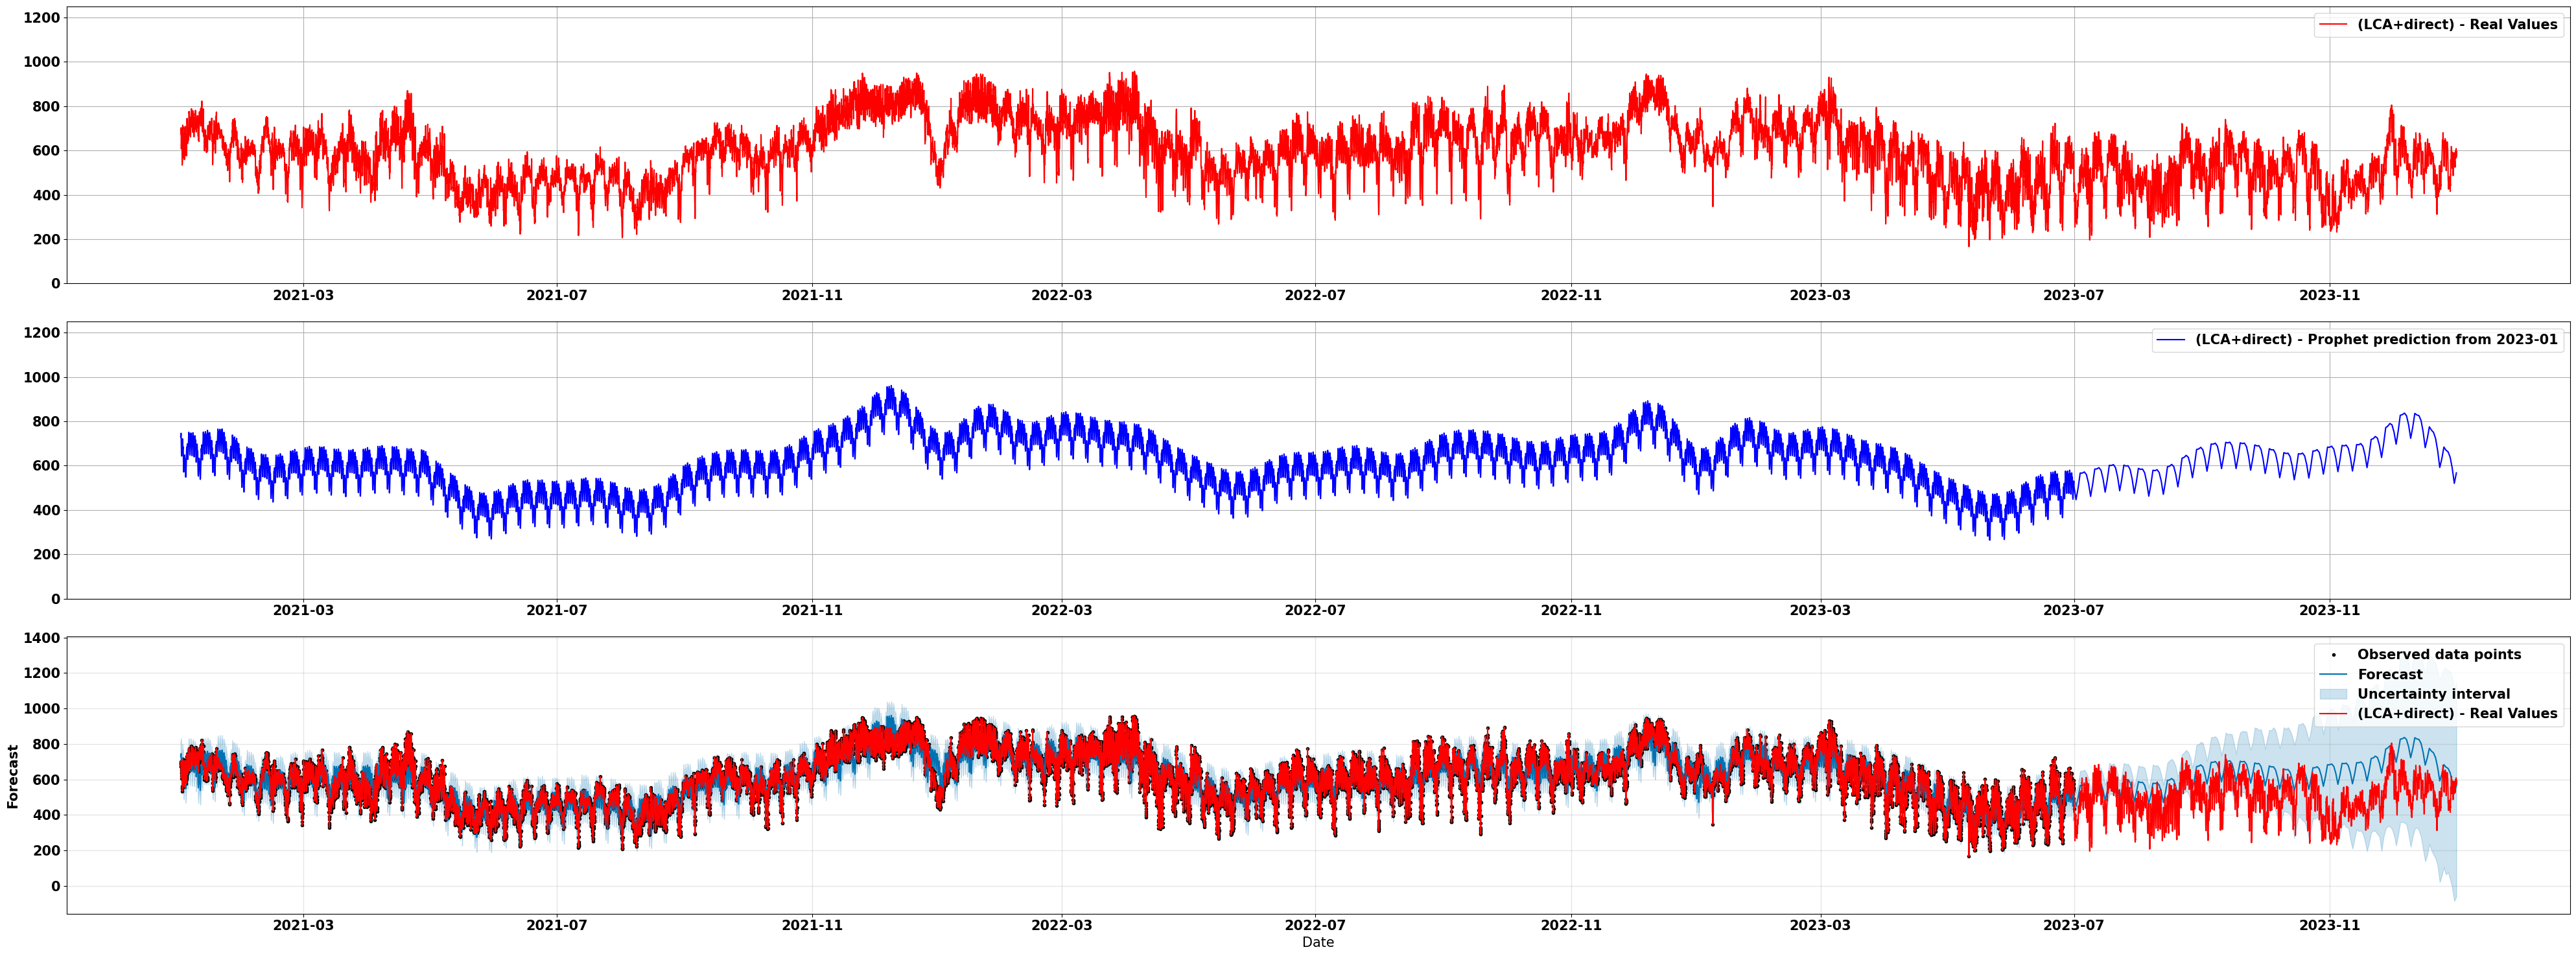

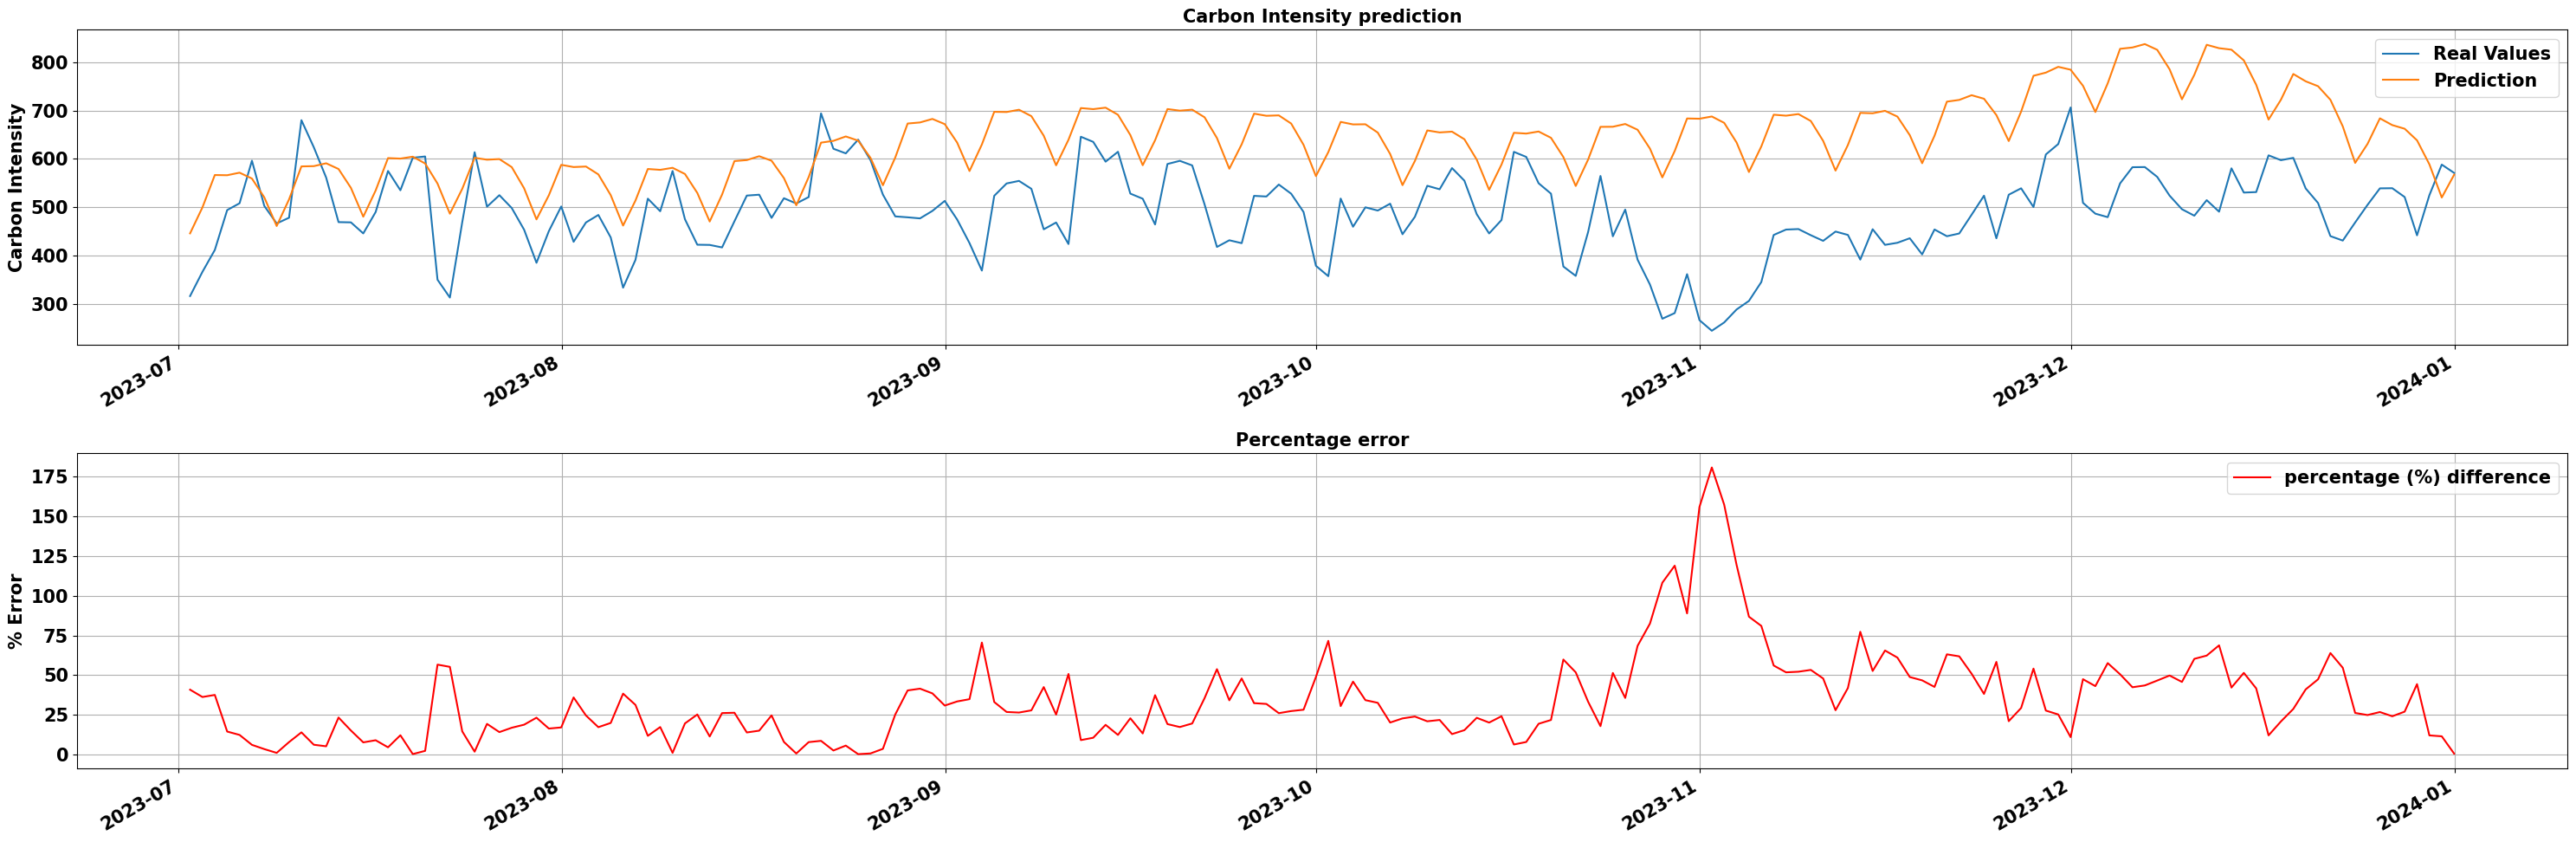

Average percentage error:
1 week: 21.64%
2 weeks: 16.05%
1 month: 16.62%
2 months: 17.04%
6 months: 34.64%


In [30]:
plotting_comparison(dataset_CI, forecast)
plotting_error(dataset_zoom)
error_computation(dataset_zoom)

### 24 months of training set

In [31]:
m = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True) # forcing to consider seasonality
m.fit(dataset_24m)
future = m.make_future_dataframe(periods=184) # Half a year of prediction
forecast = m.predict(future)

10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:19 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# Formatting of data to plot
pred_val = forecast[(forecast['ds'] > '2023-07')]
pred_val = pred_val['yhat'].reset_index()

dataset_zoom = pd.concat([real_val, pred_val], axis = 1)
dataset_zoom.drop(columns=['index'], inplace = True)
dataset_zoom['% ERR'] = (abs(dataset_zoom['yhat']-dataset_zoom['y'])/dataset_zoom['y'])*100
dataset_zoom.columns = ['Timestamp', 'Real Values', 'Prediction', '% ERR']
dataset_zoom = dataset_zoom.set_index('Timestamp')
dataset_zoom

Real Values  Prediction      % ERR
Timestamp                                              
2023-07-01 23:00:00       316.65  443.887047  40.182235
2023-07-02 23:00:00       366.69  497.958267  35.798158
2023-07-03 23:00:00       411.84  567.473377  37.789767
2023-07-04 23:00:00       494.29  566.443567  14.597416
2023-07-05 23:00:00       508.31  570.984750  12.330025
...                          ...         ...        ...
2023-12-27 23:00:00       521.19  843.817477  61.902085
2023-12-28 23:00:00       442.08  820.151175  85.520986
2023-12-29 23:00:00       525.04  770.957298  46.837821
2023-12-30 23:00:00       588.19  697.916064  18.654867
2023-12-31 23:00:00       570.99  746.497915  30.737476

[184 rows x 3 columns]

c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


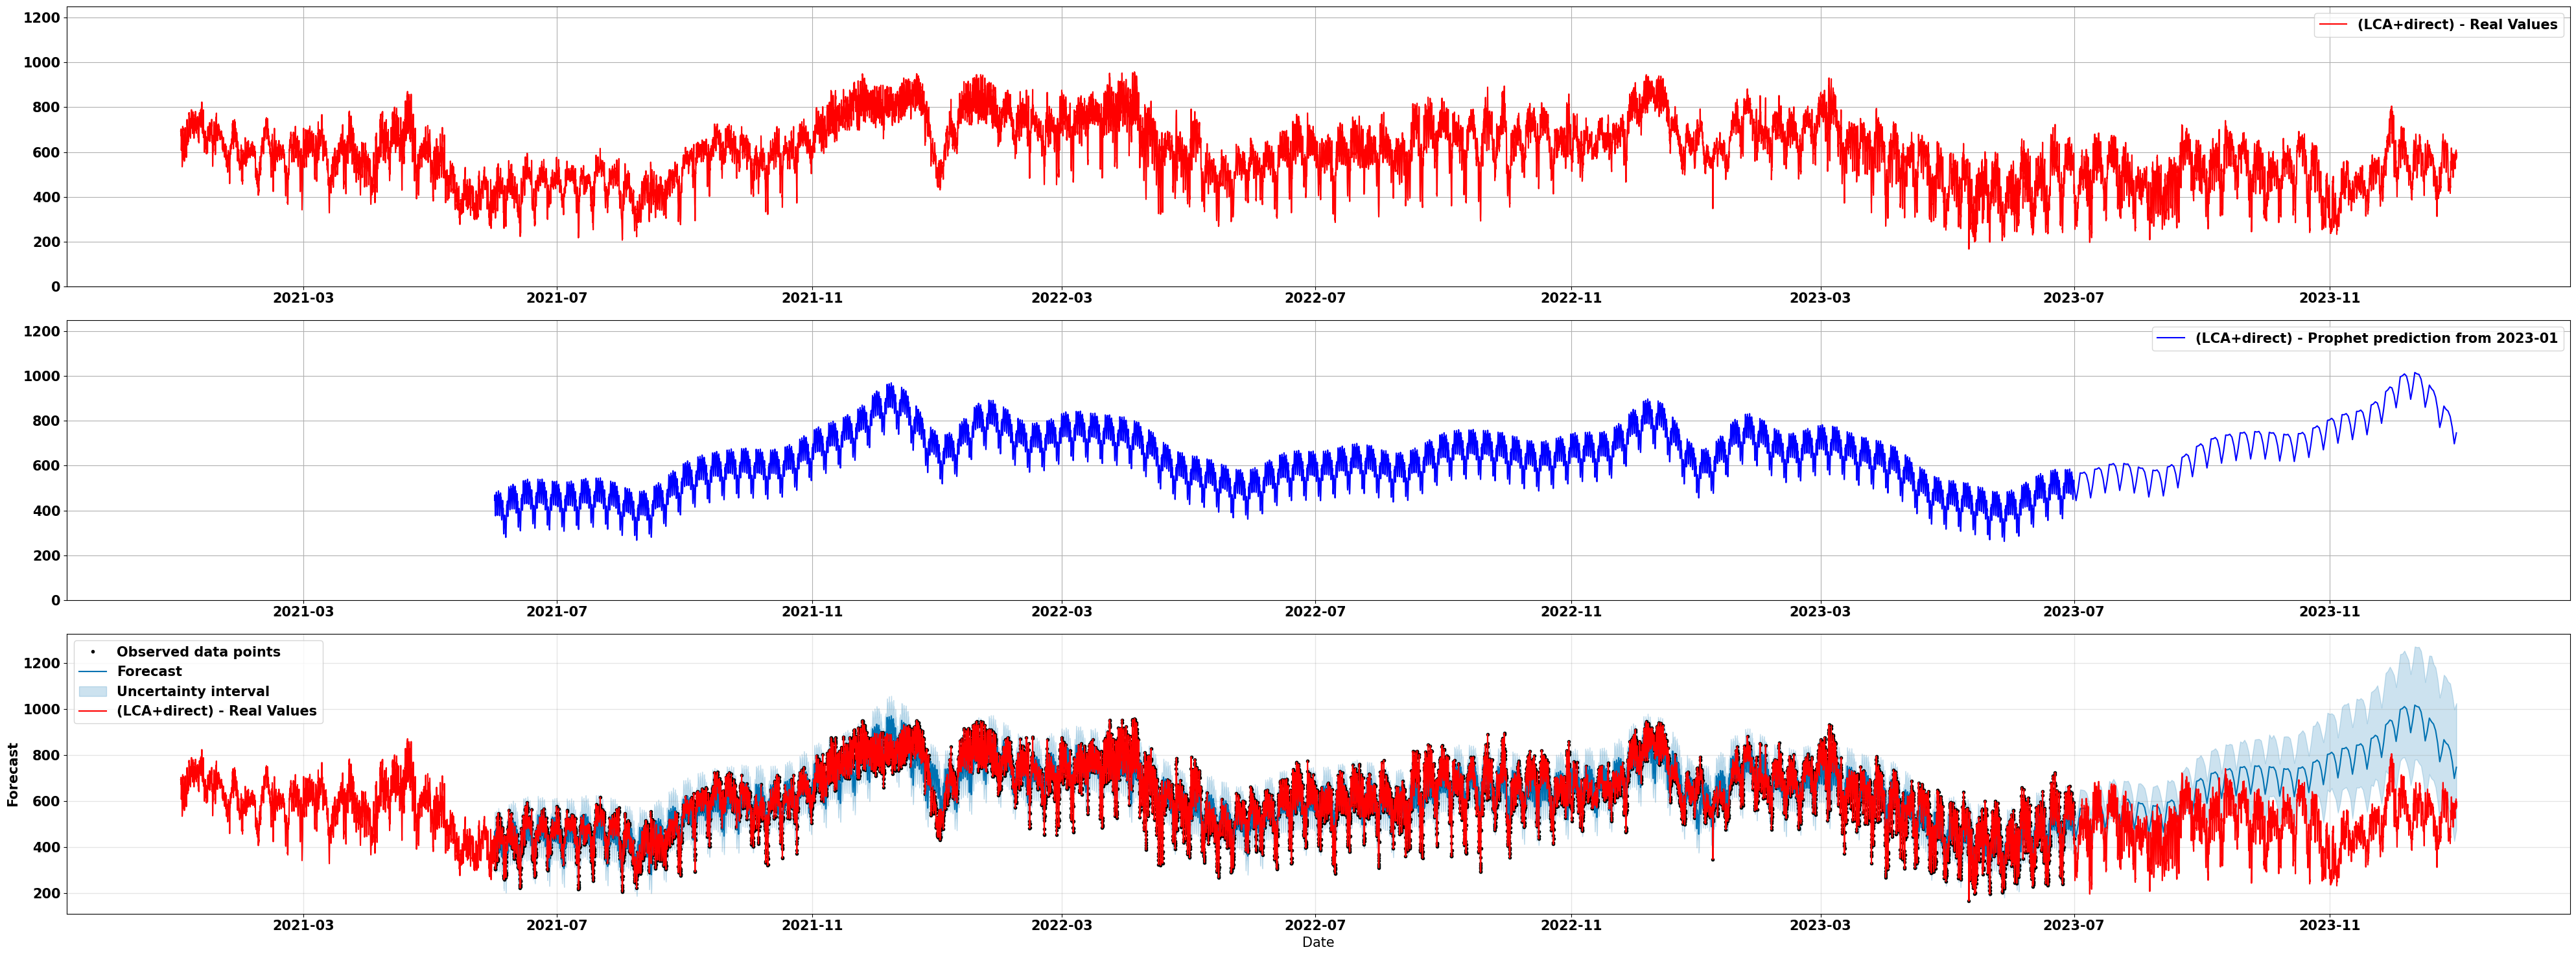

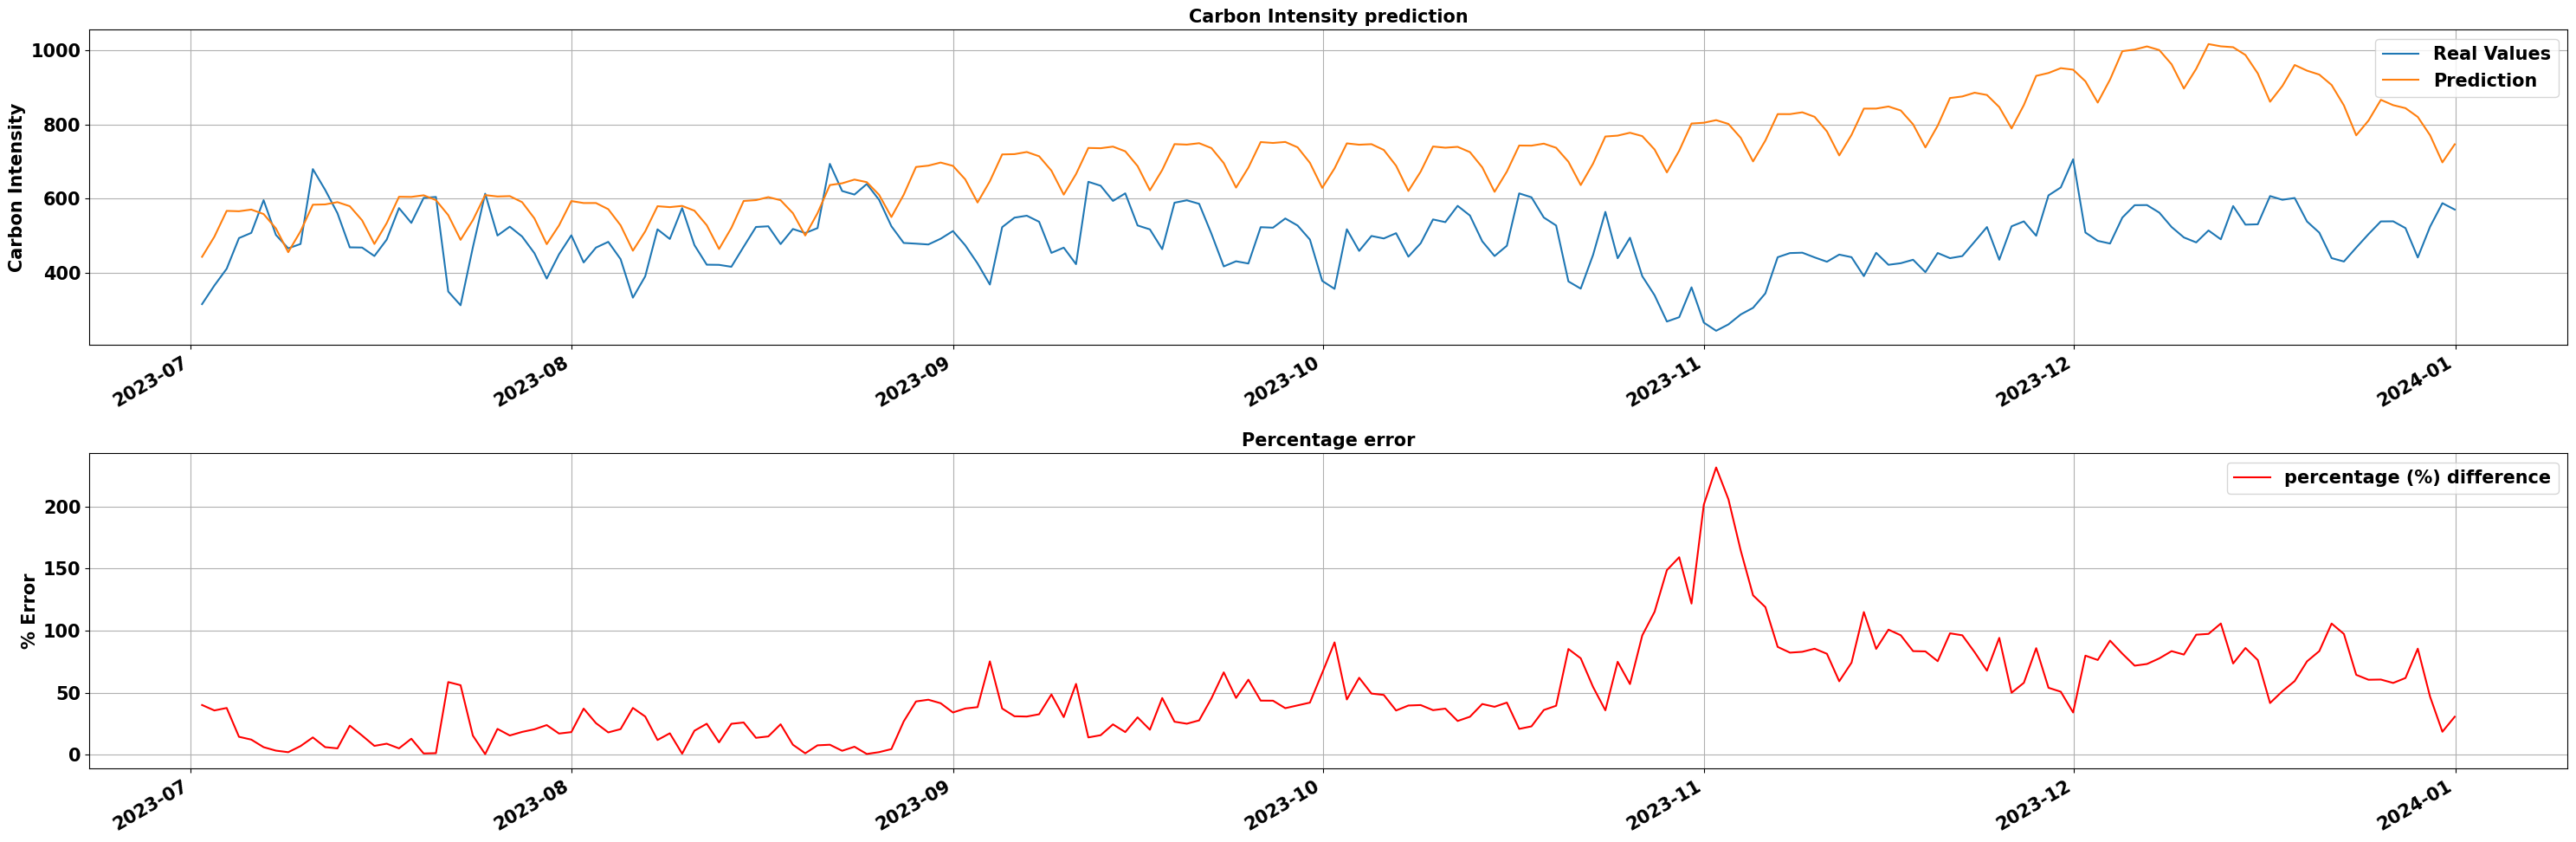

Average percentage error:
1 week: 21.49%
2 weeks: 16.04%
1 month: 16.99%
2 months: 17.43%
6 months: 50.87%


In [33]:
plotting_comparison(dataset_CI, forecast)
plotting_error(dataset_zoom)
error_computation(dataset_zoom)

### 12 months of training set

In [34]:
m = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True) # forcing to consider seasonality
m.fit(dataset_12m)
future = m.make_future_dataframe(periods=184) # Half a year of prediction
forecast = m.predict(future)

10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# Formatting of data to plot
pred_val = forecast[(forecast['ds'] > '2023-07')]
pred_val = pred_val['yhat'].reset_index()

dataset_zoom = pd.concat([real_val, pred_val], axis = 1)
dataset_zoom.drop(columns=['index'], inplace = True)
dataset_zoom['% ERR'] = (abs(dataset_zoom['yhat']-dataset_zoom['y'])/dataset_zoom['y'])*100
dataset_zoom.columns = ['Timestamp', 'Real Values', 'Prediction', '% ERR']
dataset_zoom = dataset_zoom.set_index('Timestamp')
dataset_zoom

Real Values  Prediction      % ERR
Timestamp                                              
2023-07-01 23:00:00       316.65  422.828424  33.531793
2023-07-02 23:00:00       366.69  481.828465  31.399401
2023-07-03 23:00:00       411.84  560.205911  36.025134
2023-07-04 23:00:00       494.29  558.661648  13.023053
2023-07-05 23:00:00       508.31  563.584523  10.874176
...                          ...         ...        ...
2023-12-27 23:00:00       521.19  644.479478  23.655381
2023-12-28 23:00:00       442.08  614.778290  39.064941
2023-12-29 23:00:00       525.04  552.977973   5.321113
2023-12-30 23:00:00       588.19  469.890319  20.112494
2023-12-31 23:00:00       570.99  521.665564   8.638406

[184 rows x 3 columns]

c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


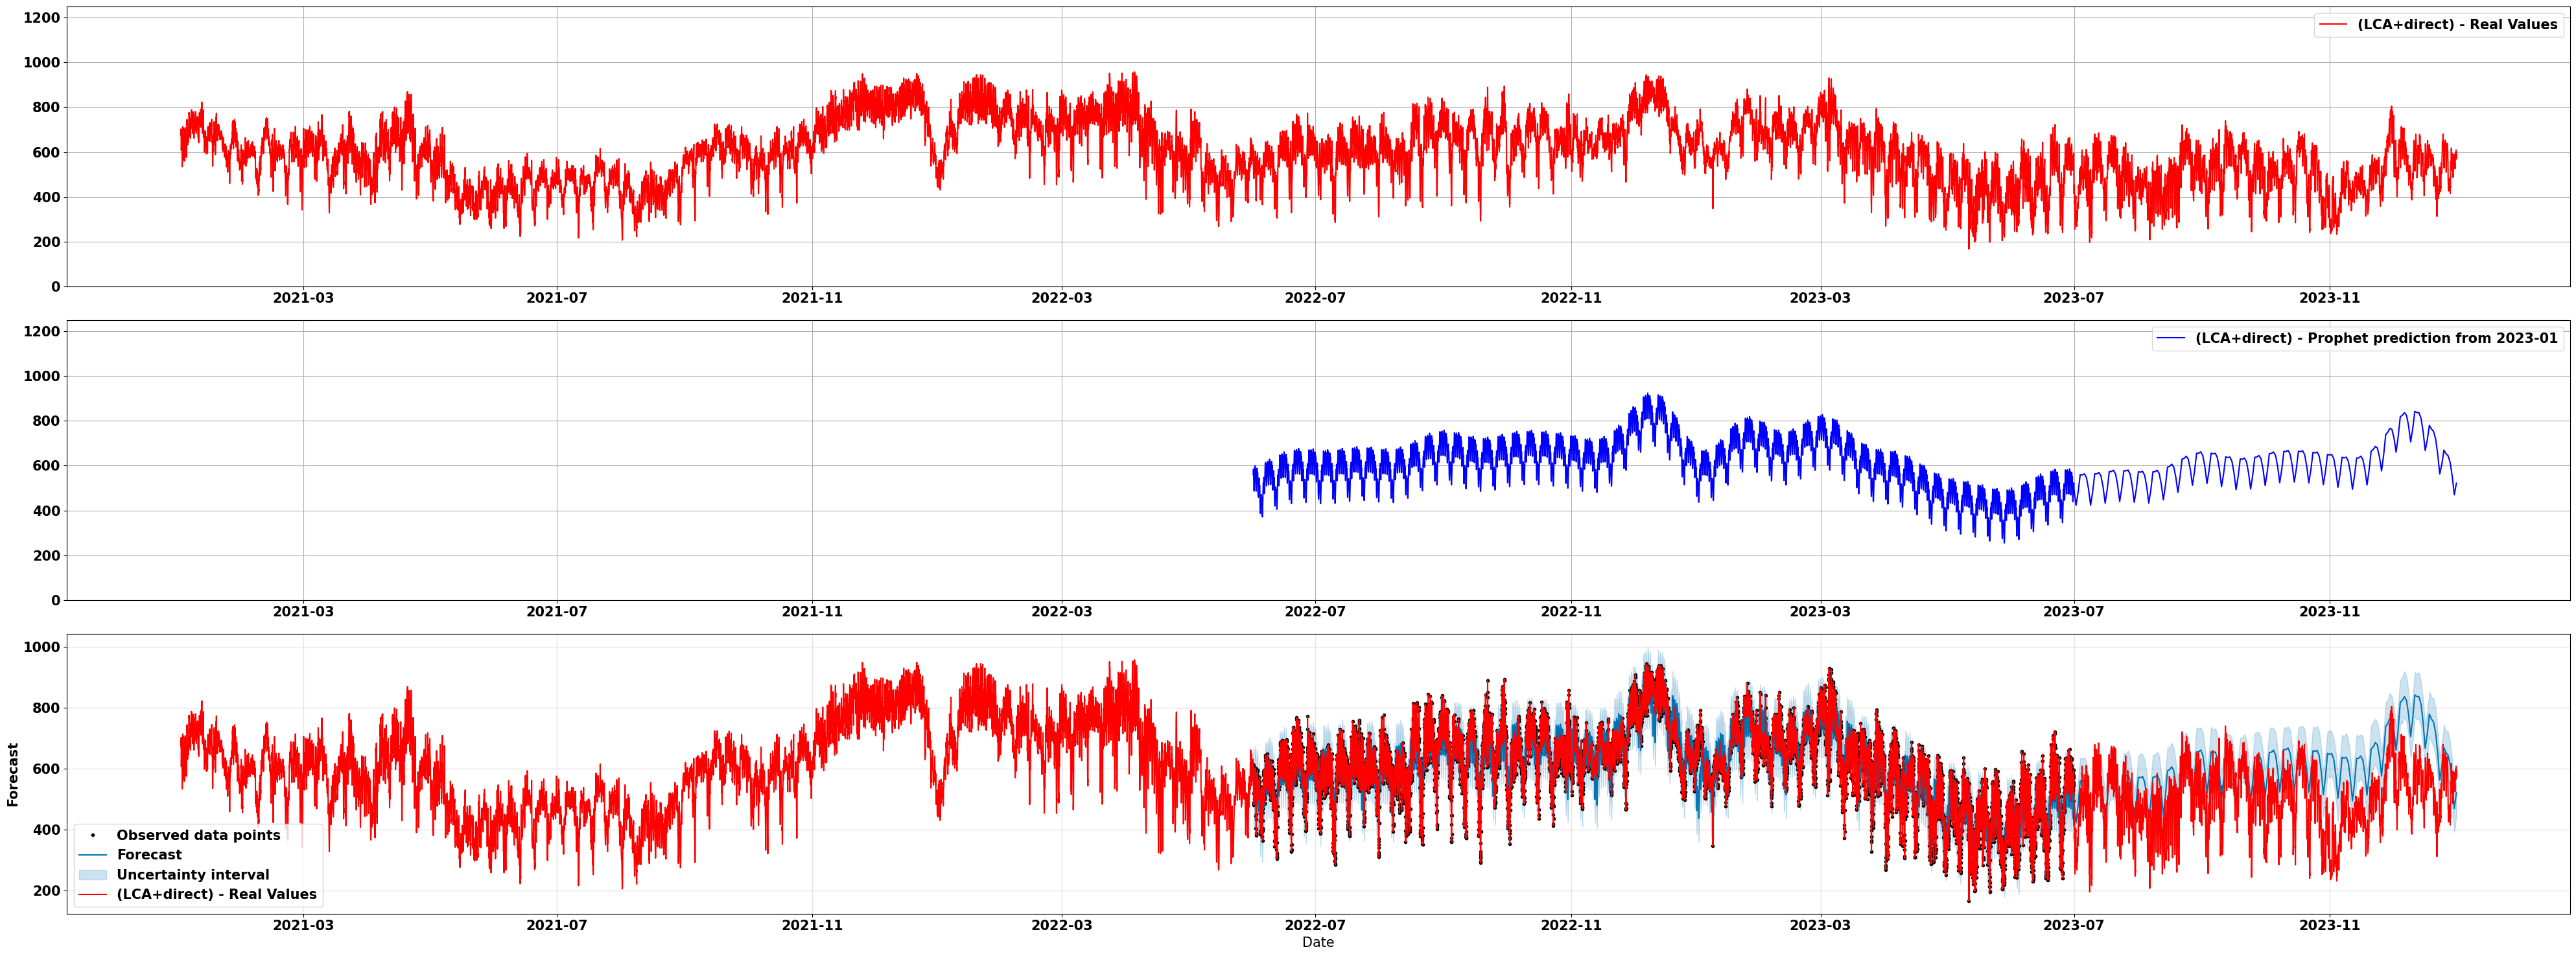

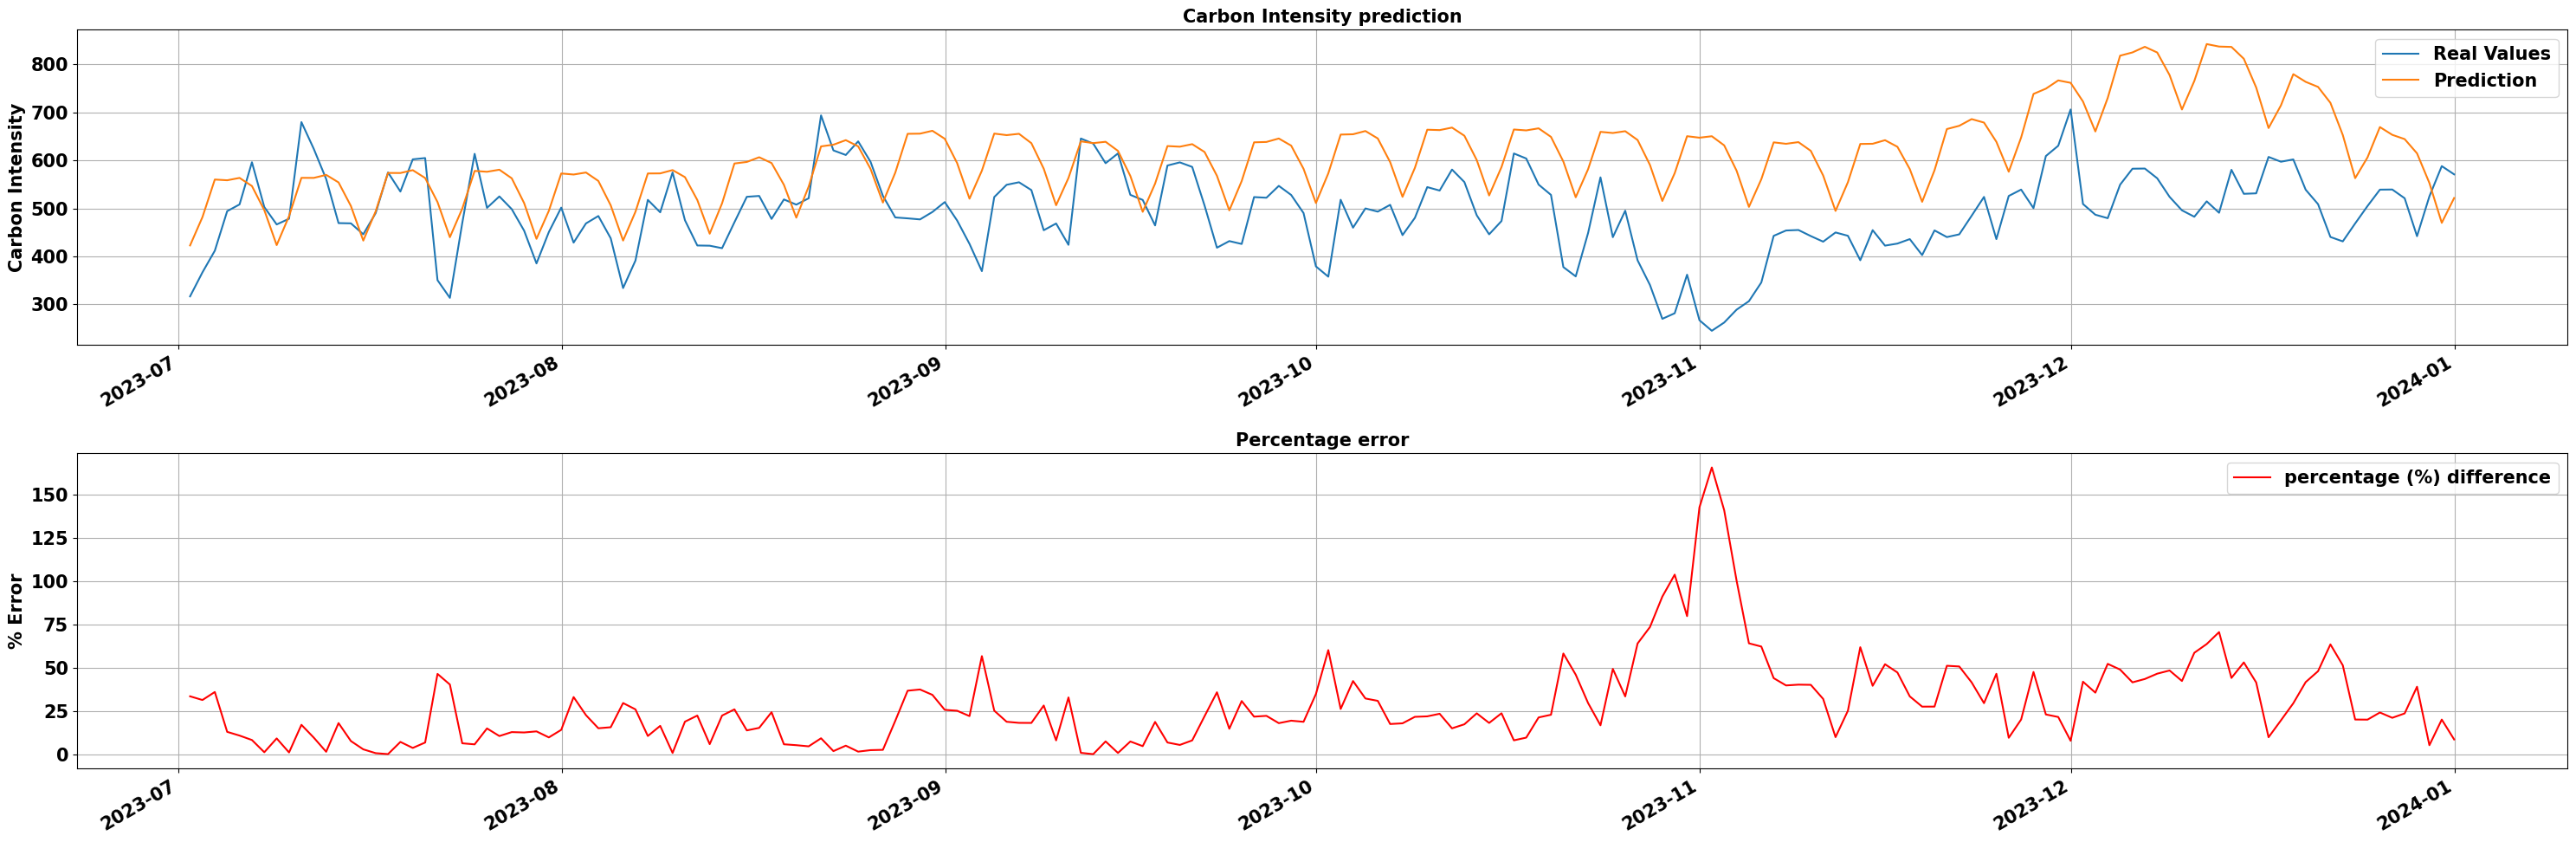

Average percentage error:
1 week: 19.21%
2 weeks: 14.21%
1 month: 13.13%
2 months: 14.33%
6 months: 28.80%


In [36]:
plotting_comparison(dataset_CI, forecast)
plotting_error(dataset_zoom)
error_computation(dataset_zoom)

### 6 months of training set

In [37]:
m = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True) # forcing to consider seasonality
m.fit(dataset_6m)
future = m.make_future_dataframe(periods=184) # Half a year of prediction
forecast = m.predict(future)

10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
# Formatting of data to plot
pred_val = forecast[(forecast['ds'] > '2023-07')]
pred_val = pred_val['yhat'].reset_index()

dataset_zoom = pd.concat([real_val, pred_val], axis = 1)
dataset_zoom.drop(columns=['index'], inplace = True)
dataset_zoom['% ERR'] = (abs(dataset_zoom['yhat']-dataset_zoom['y'])/dataset_zoom['y'])*100
dataset_zoom.columns = ['Timestamp', 'Real Values', 'Prediction', '% ERR']
dataset_zoom = dataset_zoom.set_index('Timestamp')
dataset_zoom

Real Values  Prediction      % ERR
Timestamp                                              
2023-07-01 23:00:00       316.65  474.389307  49.815035
2023-07-02 23:00:00       366.69  549.850495  49.949684
2023-07-03 23:00:00       411.84  639.343727  55.240804
2023-07-04 23:00:00       494.29  657.985620  33.117324
2023-07-05 23:00:00       508.31  671.003908  32.006828
...                          ...         ...        ...
2023-12-27 23:00:00       521.19  523.723160   0.486034
2023-12-28 23:00:00       442.08  428.182863   3.143580
2023-12-29 23:00:00       525.04  295.517218  43.715295
2023-12-30 23:00:00       588.19  160.894162  72.645886
2023-12-31 23:00:00       570.99  167.543558  70.657357

[184 rows x 3 columns]

c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\loren\miniconda3\envs\DeepLearning\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


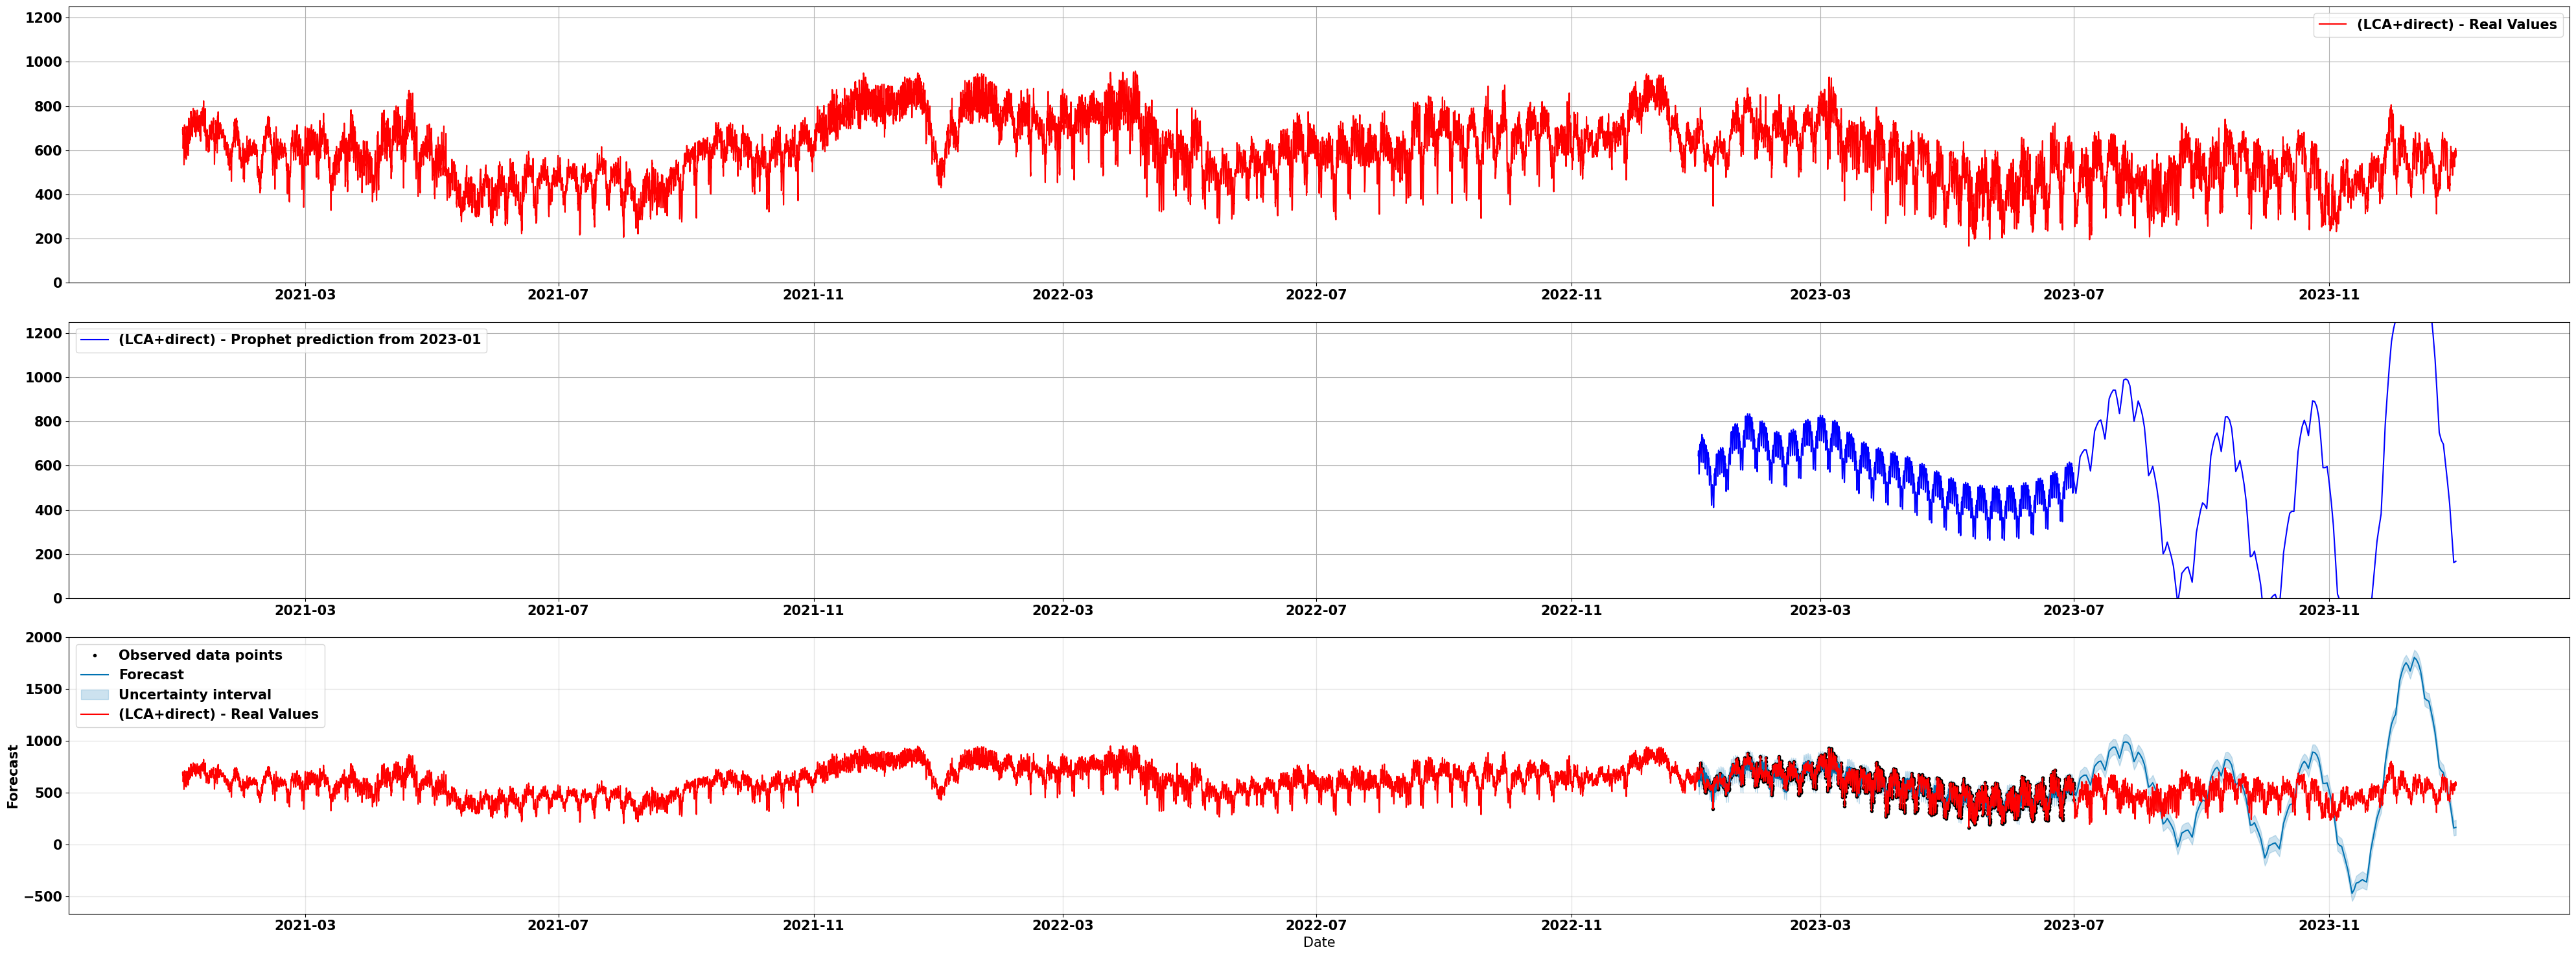

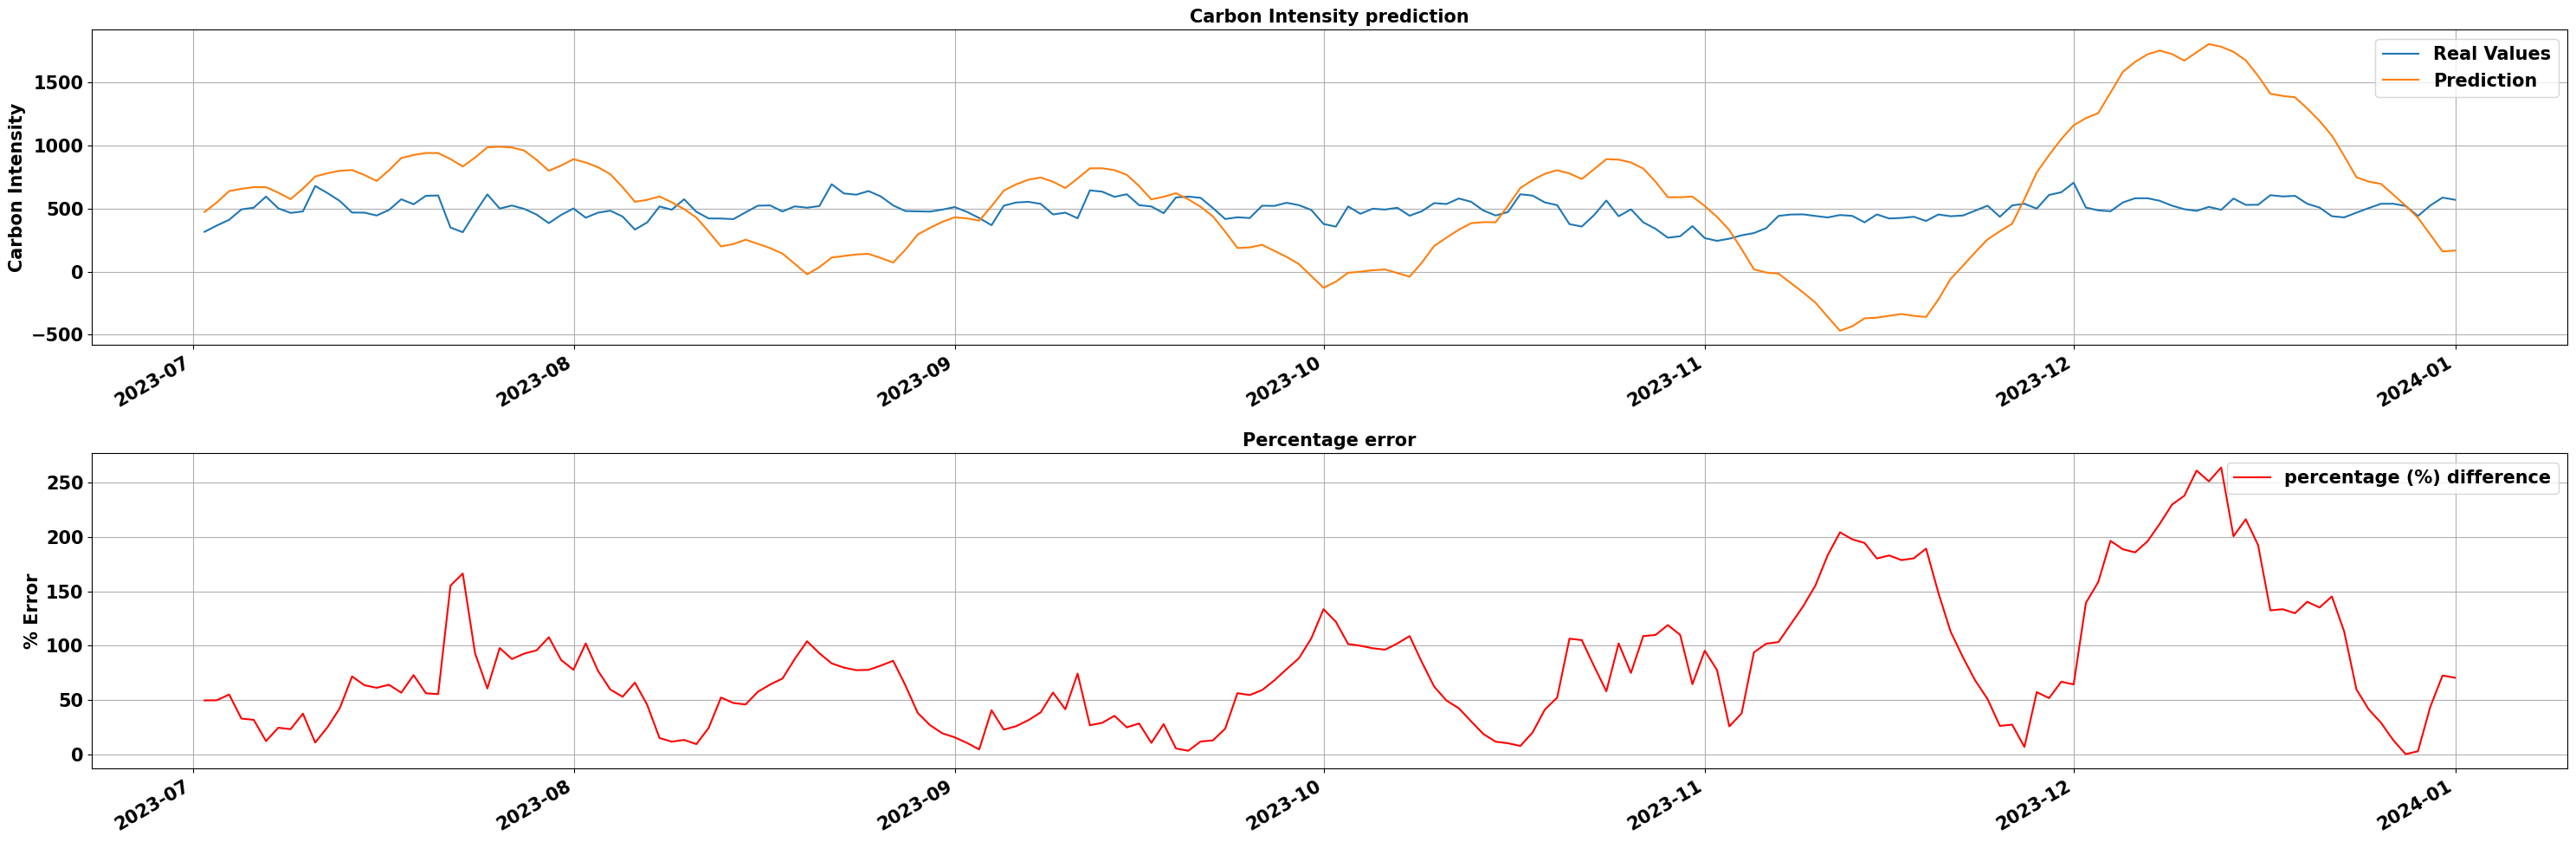

Average percentage error:
1 week: 36.77%
2 weeks: 38.08%
1 month: 64.82%
2 months: 62.35%
6 months: 81.62%


In [39]:
plotting_comparison(dataset_CI, forecast)
plotting_error(dataset_zoom)
error_computation(dataset_zoom)